In [1]:
# # ML Trader
import numpy as np
import pandas as pd

from scipy.stats import linregress
import math

import collections

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import datetime as dt

import winsound

import warnings
warnings.filterwarnings('ignore')

import cProfile

import pstats

In [2]:
def before_sema(data):   
    data['sema_list'].append(data['tick'])    
    return(data)

def after_sema(data):     
    data['sema_list'].popleft()
    data['sema_list'].append(data['tick'])
    data['sema'] = list(pd.DataFrame(list(data['sema_list'])).ewm(span=data['sema_len']).mean()[0])[-1]    
    data["df_sema_list"].append(data['sema'])
    return(data)

def before_lema(data):   
    data['lema_list'].append(data['tick'])    
    return(data)

def after_lema(data):     
    data['lema_list'].popleft()
    data['lema_list'].append(data['tick'])
    data['lema'] = list(pd.DataFrame(list(data['lema_list'])).ewm(span=data['lema_len']).mean()[0])[-1]
    data["df_lema_list"].append(data['lema'])
    return(data)

In [3]:
def print_report(data):
    display.clear_output(wait = True)
    print('--------------------------')
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-----------')
    print(data['pl_list'])
    print('--------------------------')
    return()

In [4]:
def read_data(data):
    source_file_path = f'..\\data\\yearly_tick_data\\{data["year"]}.csv'

    if data['input_rows'] is None:
        data["df"] = pd.read_csv(source_file_path)
    else:
        data["df"] = pd.read_csv(source_file_path, nrows=data['input_rows'])
        
    data["df"] = data["df"][data["df"]['DateTime'].str.contains('|'.join(data['date_list']))]
    
    data["df"]['tick'] = np.float()
    data["df"]['sema'] = np.float()
    data["df"]['lema'] = np.float()
    
    return(data["df"])

In [5]:
def get_dir(data):
    
    if data['sema'] > data['lema']:
        data['position'] = 1

    elif data['sema'] < data['lema']:
        data['position'] = -1
    
    return(data)

In [6]:
def after_dir(data):   
    
    data['dir_list'].popleft()
    data['dir_list'].append(data['position'])   
    
    if sum(data['dir_list']) != 0:
        data['dir_change'] = False

    elif sum(data['dir_list']) == 0:
        data['dir_change'] = True

    return(data)

In [7]:
def make_order(data):
    if not data['open_order']:
        if data['dir_change']:
            if data['position'] > 0 and data['angle'] >= 20:
                data['order_ask_price'] = data['ask']
                data['open_order'] = True
                data['open_order_type'] = 'long'
                
                data['buy_markers_x'].append(data['i_list'][-1])
                data['buy_markers_y'].append(data['ask'])
                
            elif data['position'] < 0 and data['angle'] <= -20:
                data['order_bid_price'] = data['bid']
                data['open_order'] = True
                data['open_order_type'] = 'short'
                
                data['buy_markers_x'].append(data['i_list'][-1])
                data['buy_markers_y'].append(data['bid'])
                
    return(data)

In [8]:
def close_order(data):
    if data['open_order']:
        if data['dir_change']:
            if data['position'] < 0 and data['angle'] <= -20:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['bid'])               
                
            elif data['position'] > 0 and data['angle'] >= 20:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['ask'])                  
                
    return(data)

In [9]:
def angle_close(data):
    if data['open_order']:
        if data['open_order_type'] == 'short':
            if data['lema'] - data['tick'] <= 0.0002 and data['angle'] >= 30:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['ask'])  
                
        if data['open_order_type'] == 'long':
            if data['tick'] - data['lema'] >= 0.0002 and data['angle'] <= -30:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['bid'])                  
                
    return(data)

In [10]:
def tick_close(data):
    if data['open_order']:
        if data['open_order_type'] == 'short':
            if data['tick'] - data['lema'] >= 0 and data['angle'] >= 20:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['ask'])  
                
        if data['open_order_type'] == 'long':
            if data['lema'] - data['tick'] >= 0 and data['angle'] <= -20:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['bid'])                  
                
    return(data)

In [11]:
def get_date_list(data):
    
    data['start_date'] = dt.datetime(year=data['start_date']['year'],
                      month=data['start_date']['month'],
                      day=data['start_date']['date'])

    data['end_date'] = dt.datetime(year=data['end_date']['year'],
                      month=data['end_date']['month'],
                      day=data['end_date']['date'])

    
    date_list = list(pd.date_range(data['start_date'],data['end_date'],freq='d').values)
    data['date_list'] = [str(x).split('T')[0].replace('-','') for x in date_list]
    return(data)

In [12]:
def get_run_duration(data):
    run_time = len(data["date_list"]) * 6
    hours = run_time//60
    mins = run_time%60
    print(f'Approx run time : {hours}-hours : {mins}-mins')

In [13]:
def split_date_col(data):
    data['total_df']['year_val'] = [x.year for x in data['total_df']['date']]
    data['total_df']['month_val'] = [x.month for x in data['total_df']['date']]
    data['total_df']['date_val'] = [x.day for x in data['total_df']['date']]
    data['total_df']['hour_val'] = [x.hour for x in data['total_df']['date']]
    data['total_df']['minute_val'] = [x.minute for x in data['total_df']['date']]

In [14]:
def get_date_lines(data):
    data['line_list'] = []
    
    for dt_val  in data['date_list']:    
        data['line_list'].append(data["df"][data["df"]['DateTime'].str.contains(dt_val)].index[0])
    
    return(data)

In [15]:
def plot_graph(data):
    fig, ax1 = plt.subplots(figsize=(50,10))
    ax2 = ax1.twinx()

    x_axis = np.arange(0,len(data["df"]['tick']))

    ax1.plot(x_axis, data["df"]['tick'], label='tick', color='green', linestyle='dotted')
    ax1.plot(x_axis, data["df"]['sema'], label='sema', color='black')
    ax1.plot(x_axis, data["df"]['lema'], label='lema', color='blue')

    data = get_date_lines(data)

    for x_val in data['line_list']:
        plt.axvline(x=x_val, color='black')

    ax1.scatter(data['buy_markers_x'], data['buy_markers_y'], s=300, c='b')
    ax1.scatter(data['sell_markers_x'], data['sell_markers_y'], s=300, c='r')

    ax2.plot(data['df']["angle"], c='g', label = 'angle', linestyle = 'dashed')
    ax2.plot(data['df']["long_angle"], c='b', label = 'long_angle', linestyle = 'dashed')

    legend = ax1.legend(loc='upper left', fontsize='xx-large')
    legend = ax2.legend(loc='upper right', fontsize='xx-large')
    
    ax1.tick_params(axis='x', colors='red', labelsize = 25)
    ax1.tick_params(axis='y', colors='red', labelsize = 25)
    ax2.tick_params(axis='y', colors='red', labelsize = 25)


    plt.xlabel('tick num')
    plt.ylabel('prices')
    plt.title('trade chart')
    plt.grid()
    plt.show()

In [16]:
def print_report(data):
    pl_list = list(data['pl_list'])
    net_pl = round(np.sum(pl_list),5)

    positive_pls = [i for i in pl_list if i > 0]
    negative_pls = [i for i in pl_list if i < 0]

    num_positive = len(positive_pls)
    num_negative = len(negative_pls)

    sum_positive = round(np.sum(positive_pls),5)
    sum_negative = round(np.sum(negative_pls),5)
    sum_total    = round(sum_positive + abs(sum_negative),5) 

    avg_positive = round(np.mean(positive_pls),5)
    avg_negative = round(np.mean(negative_pls),5)

    
    print('==============================')
    print(f'date_val          : {data["date_list"]}')    
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-------------')
    print(f'net_pl            : {net_pl}/{sum_total}')  
    print('-------------')
    print(f'+ve               : num= {num_positive}    sum= +{sum_positive}    avg= +{avg_positive}')
    print(f'-ve               : num= {num_negative}    sum= {sum_negative}    avg= {avg_negative}')
    print('==============================')

In [17]:
def get_slope(data):
    pip_decimal_num = 6
    
    data['y_axis'] = list(np.round(data['y_axis'],pip_decimal_num))
    ma_len = len(data['y_axis'])
    
    x_axis = []
    for i in range(ma_len):
        x_axis.append(1 + ((i+1) * 10**(-pip_decimal_num)))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, data['y_axis'])
    data['angle'] = math.degrees(math.atan(slope_tick))
    data['angle_list'].append(data['angle'])
    
    return(data)

In [18]:
def get_long_slope(data):
    pip_decimal_num = 6
    
    data['long_y_axis'] = list(np.round(data['long_y_axis'],pip_decimal_num))
    ma_len = len(data['long_y_axis'])
    
    x_axis = []
    for i in range(ma_len):
        x_axis.append(1 + ((i+1) * 10**(-pip_decimal_num)))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, data['long_y_axis'])
    data['long_angle'] = math.degrees(math.atan(slope_tick))
    data['long_angle_list'].append(data['long_angle'])
    
    return(data)

In [19]:
def run_engine(data):
    for i in tqdm(range(0, len(data["df"]))):
        
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["tick_list"].append(data['tick'])
        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)                 
        # ----------------------------------------------------------


        # Get Angle --------------------------------
        data['y_axis'] = list(data["tick_list"][-data['angle_len']:])        
        if 0 not in data['y_axis']:            
            if len(data['y_axis']) >= data['angle_len']:
                data = get_slope(data)            
        # ----------------------------------------------------------         
                       
                
            
        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)                  
        # ----------------------------------------------------------

        # Get long Angle --------------------------------
        data['long_y_axis'] = list(data["tick_list"][-data['long_angle_len']:])        
        if 0 not in data['long_y_axis']:            
            if len(data['long_y_axis']) >= data['long_angle_len']:
                data = get_long_slope(data)            
        # ----------------------------------------------------------                                        
             
        data['i_list'].append(i)
        data = get_dir(data)

        # Get Dirs --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
            
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------

        data = angle_close(data)
        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    

    
    # Adjust df len to lema(shortest) len
    data["df"] = data['df'][-len(data["df_lema_list"]):]   
    data["df"] = data["df"].reset_index(drop = True)    
    
    # Assign sema, lema and tick to df
    data["df"]['lema'] = data["df_lema_list"]            
    data["df"]['sema'] = list(data["df_sema_list"])[-len(data["df_lema_list"]):]    
    data['df']["tick"] = list(data["tick_list"])[-len(data["df_lema_list"]):]
    data['df']["angle"] = list(data["angle_list"])[-len(data["df_lema_list"]):]
    data['df']["long_angle"] = list(data["long_angle_list"])[-len(data["df_lema_list"]):]
    
    # Adjust buy sell markers to the shortened df
    data['len_to_subtract'] = data['lema_len']
    data['buy_markers_x'] = list(np.array(data['buy_markers_x']) - data['len_to_subtract'])
    data['sell_markers_x'] = list(np.array(data['sell_markers_x']) - data['len_to_subtract'])    
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [20]:
data = {}
data["year"] = 2021
data['total_df'] = pd.DataFrame()
data['sema_list'] = collections.deque()
data['lema_list'] = collections.deque()
data['dir_list'] = collections.deque()
data['pl_list'] =  collections.deque()
data['dt_list'] =  collections.deque()
data['angle_list'] = []
data['long_angle_list'] = []
data['tick_list'] = []
data['df_sema_list'] = []
data['df_lema_list'] = []

data['i_list'] = []


data['buy_markers_x'] = []
data['buy_markers_y'] = []

data['sell_markers_x'] = []
data['sell_markers_y'] = []

data['open_order_type'] = None

In [21]:
data['input_rows'] = None

data['start_date'] = {'year':2021, 'month':2, 'date':8}
data['end_date']   = {'year':2021, 'month':2, 'date':12}

data['sema_len'] = 2000
data['lema_len'] = 50000

data['angle_len'] = 2000
data['long_angle_len'] = 10000

  0%|                                     | 403/314312 [00:00<01:22, 3823.31it/s]

Record num : 314312


100%|██████████████████████████████████| 314312/314312 [1:41:14<00:00, 51.74it/s]


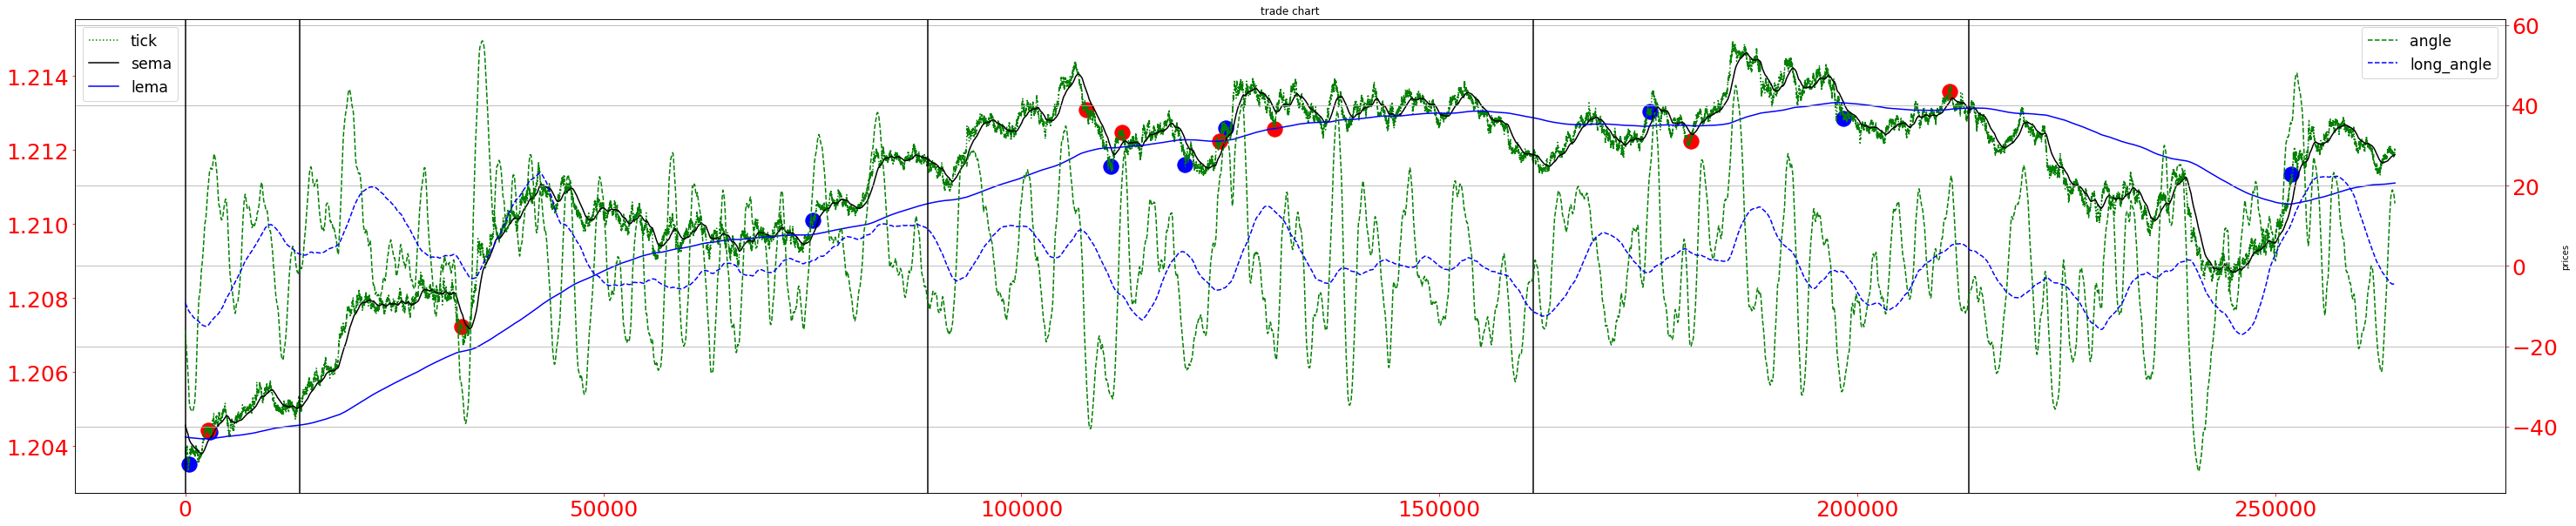

date_val          : ['20210208', '20210209', '20210210', '20210211', '20210212']
Total PL : 0.0020000000000000005
-------------
net_pl            : 0.002/0.0098
-------------
+ve               : num= 2    sum= +0.0059    avg= +0.00295
-ve               : num= 5    sum= -0.0039    avg= -0.00078
Wall time: 1h 41min 20s


In [22]:
%%time
data = get_date_list(data)
read_data(data)
#data["df"] = data["df"][0:6000]
print(f'Record num : {len(data["df"])}')    
data["df"] = data["df"].reset_index(drop = True)
data['df']['i'] = np.int()
data['open_order'] = False    
data = run_engine(data)

plot_graph(data)
print_report(data)
data['total_df'] = pd.DataFrame({'date':data['dt_list'], 'pls': data['pl_list']})
split_date_col(data)
data['total_df'] = data['total_df'][['date', 'year_val', 'month_val', 'date_val', 'hour_val','minute_val', 'pls']]
data["total_df"] = data["total_df"].reset_index(drop = True)    
data['file_name'] = f'data\{data["start_date"].year}-{data["start_date"].month}-({data["start_date"].day}-{data["end_date"].day}).csv'

data['total_df'].to_csv(data['file_name'], index = False) 

In [23]:
print(data['total_df'].groupby(['date_val'])['pls'].sum())

date_val
8    -0.0009
9     0.0029
10    0.0015
11   -0.0015
Name: pls, dtype: float64


In [24]:
data['total_df']['pls'].value_counts()

-0.0009    2
 0.0029    1
-0.0008    1
-0.0007    1
-0.0006    1
-0.0000    1
 0.0030    1
Name: pls, dtype: int64

In [25]:
winsound.PlaySound('C:\\Windows\\Media\\chimes.wav', winsound.SND_ASYNC)

In [26]:
data['total_df']

,date,year_val,month_val,date_val,hour_val,minute_val,pls
0,2021-02-08 16:59:02,2021,2,8,16,59,-0.0009
1,2021-02-09 08:26:15,2021,2,9,8,26,0.0029
2,2021-02-10 09:08:42,2021,2,10,9,8,0.0030
3,2021-02-10 09:53:45,2021,2,10,9,53,-0.0009
4,2021-02-10 13:08:32,2021,2,10,13,8,-0.0006
5,2021-02-10 14:02:30,2021,2,10,14,2,-0.0000
6,2021-02-11 11:19:24,2021,2,11,11,19,-0.0008
7,2021-02-11 20:43:22,2021,2,11,20,43,-0.0007
